In [1]:
NEW_DATA_DIR = './data'
TRAIN_DIR = NEW_DATA_DIR + '/Train'
TEST_DIR = NEW_DATA_DIR + '/Test'
VALID_DIR = NEW_DATA_DIR + '/Valid'
test_size = 0.10

import keras
import cv2

def blur(img):
    rand_int = np.random.randint(11)
    if rand_int <= 1:
        blurred = (cv2.blur(img,(5,5)))
        return blurred
    if rand_int <= 3:
        kernel = np.ones((6, 6), np.float32)/20
        filtered = cv2.filter2D(img, -1, kernel)
        return filtered
    return img

#image_size = (136, 204)
image_size = (299, 299)
batch_size = 10

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5],
    preprocessing_function= blur)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                TRAIN_DIR,
                target_size=(image_size[0], image_size[1]),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

# Flow validation images in batches of 20 using test_datagen generator
test_generator = validation_datagen.flow_from_directory(
                TEST_DIR, # Source directory for the validation images
                target_size=(image_size[0], image_size[1]),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

Using TensorFlow backend.


Found 1639 images belonging to 4 classes.
Found 182 images belonging to 4 classes.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121,DenseNet201
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

img_size = 299

def get_model(model_name) :
    if model_name == 'MobileNet' :
        base_model=MobileNet(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    elif model_name == 'VGG16' : 
        base_model=vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    elif model_name == 'DenseNet' :
        base_model = DenseNet121(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    elif model_name == 'DenseNet201' :
        base_model = DenseNet201(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    elif model_name == 'Inception' :
        base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    elif model_name == 'ResNet' :
        base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.3)(x)
    x=Dense(256,activation='relu')(x) #dense layer 2
    preds=Dense(4,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds,name=model_name)
    model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    return model

In [5]:
import numpy as np

# ,'VGG16' 'MobileNet' 'DenseNet201', 'Inception','ResNet',
nets = ['MobileNet']
num_epochs = 85
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

histories = []
for network in nets:
    print('---------------------- TRAIN %s ----------------------'%network)
    reduce_lr =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10,verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,min_lr = 1e-5)
    es = EarlyStopping(monitor = "val_loss" , verbose = 1 , mode = 'min' , patience = 50 )
    mc = ModelCheckpoint('checkpoints/%s/best_model_loss.h5'%network, monitor = 'loss' , mode = 'min', verbose = 1 , save_best_only = True)
    mc_val = ModelCheckpoint('checkpoints/%s/best_model_val_loss.h5'%network, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)
    model = get_model(network)
    model.load_weights('checkpoints/%s/best_model_val_loss.h5'%network)
    history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[reduce_lr,es,mc,mc_val],
                    epochs=num_epochs)
    histories.append(history)

---------------------- TRAIN MobileNet ----------------------


C:\Users\Luca\Anaconda3\envs\tf_gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 18 steps
Epoch 1/85
162/163 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9524
Epoch 00001: loss improved from inf to 0.16977, saving model to checkpoints/MobileNet/best_model_loss.h5

Epoch 00001: val_loss improved from inf to 0.18911, saving model to checkpoints/MobileNet/best_model_val_loss.h5
163/163 [==============================] - 70s 431ms/step - loss: 0.1697 - accuracy: 0.9527 - val_loss: 0.1891 - val_accuracy: 0.9389
Epoch 2/85
162/163 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9543
Epoch 00002: loss improved from 0.16977 to 0.13043, saving model to checkpoints/MobileNet/best_model_loss.h5

Epoch 00002: val_loss did not improve from 0.18911
163/163 [==============================] - 68s 415ms/step - loss: 0.1311 - accuracy: 0.9540 - val_loss: 0.2308 - val_accuracy: 0.9278
Epoch 3/85
162/163 [============================>.] - ETA: 0s - los

Epoch 23/85
162/163 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9809
Epoch 00023: loss did not improve from 0.04946

Epoch 00023: val_loss did not improve from 0.16044
163/163 [==============================] - 69s 422ms/step - loss: 0.0590 - accuracy: 0.9810 - val_loss: 0.1760 - val_accuracy: 0.9167
Epoch 24/85
162/163 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9747
Epoch 00024: loss did not improve from 0.04946

Epoch 00024: val_loss did not improve from 0.16044
163/163 [==============================] - 69s 424ms/step - loss: 0.0738 - accuracy: 0.9742 - val_loss: 0.1609 - val_accuracy: 0.9500
Epoch 25/85
162/163 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9697
Epoch 00025: loss did not improve from 0.04946

Epoch 00025: val_loss did not improve from 0.16044
163/163 [==============================] - 68s 416ms/step - loss: 0.0915 - accuracy: 0.9699 - val_loss: 0.4163 - val_accuracy: 0.9111
Epoch 26/8

Epoch 47/85
162/163 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9969
Epoch 00047: loss improved from 0.00992 to 0.00971, saving model to checkpoints/MobileNet/best_model_loss.h5

Epoch 00047: val_loss did not improve from 0.16044
163/163 [==============================] - 67s 413ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.3215 - val_accuracy: 0.9333
Epoch 48/85
162/163 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9969
Epoch 00048: loss improved from 0.00971 to 0.00783, saving model to checkpoints/MobileNet/best_model_loss.h5

Epoch 00048: val_loss did not improve from 0.16044
163/163 [==============================] - 67s 412ms/step - loss: 0.0078 - accuracy: 0.9969 - val_loss: 0.2885 - val_accuracy: 0.9389
Epoch 49/85
162/163 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9981
Epoch 00049: loss improved from 0.00783 to 0.00490, saving model to checkpoints/MobileNet/best_model_loss.h5

Epoch 000

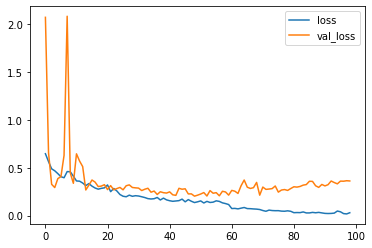

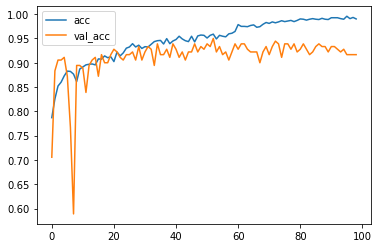

In [12]:
import matplotlib.pyplot as plt

for history in histories:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss,label='loss')
    plt.plot(val_loss,label='val_loss')
    plt.legend()
    #plt.savefig('loss.png')
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(acc,label='acc')
    plt.plot(val_acc,label='val_acc')
    plt.legend()
    #plt.savefig('acc.png')
    plt.show()

In [21]:
import numpy as np

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[reduce_lr,es,mc,mc_val],
                    epochs=55)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 409 steps, validate for 45 steps
Epoch 1/25
408/409 [============================>.] - ETA: 0s - loss: 1.3032 - accuracy: 0.3219
Epoch 00001: loss improved from inf to 1.30310, saving model to checkpoints/Inception/best_model_loss.h5

Epoch 00001: val_loss improved from inf to 5.42784, saving model to checkpoints/Inception/best_model_val_loss.h5
409/409 [==============================] - 78s 191ms/step - loss: 1.3030 - accuracy: 0.3217 - val_loss: 5.4278 - val_accuracy: 0.3389
Epoch 2/25
408/409 [============================>.] - ETA: 0s - loss: 1.2642 - accuracy: 0.3164
Epoch 00002: loss improved from 1.30310 to 1.26401, saving model to checkpoints/Inception/best_model_loss.h5

Epoch 00002: val_loss improved from 5.42784 to 1.27709, saving model to checkpoints/Inception/best_model_val_loss.h5
409/409 [==============================] - 71s 173ms/step - loss: 1.2640 - accuracy: 0.3162 - val_loss: 1.2771 - val_accuracy: 0.3278
E

KeyboardInterrupt: 